Un po' di tempo fa ho affrontato in un [mio articolo](https://massimilianomoraca.it/blog/gis/da-point-a-pointz/) il problema dell'aggiunta della coordinata altimetrica ad un dataset di punti usando QGIS. In questo JupyterNotebook affronterò il problema usando Python.


## Prima di iniziare


### Librerie
Per raggiungere l'obiettivo userò essenzialmente `geopandas`, `shapely` e `rasterio`. In verità tra gli import troverai anche `pathlib` e `matplotlib` ma non sono essenziali per la corretta riuscita del procedimento.



In [7]:
import pathlib

import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show, show_hist
import matplotlib.pyplot as plt
from shapely.geometry import Point

### Fonti dati
Come [DEM](https://massimilianomoraca.it/blog/gis/3d-open-source/) ho usato un tile del progetto [TIN Italy](http://tinitaly.pi.ingv.it/Download_Area2.html) a sua volta ritagliato e su cui ho generato con QGIS quattro punti random.


In [8]:
sample_data = pathlib.Path.cwd().parent.parent.joinpath('sample_data/add_z')
dem = sample_data.joinpath('clip_dem.tif')
points = sample_data.joinpath('points.shp')

## Contenuti
- [1. Quota altimetrica costante](#1.-Quota-altimetrica-costante)
- [2. Quota altimetrica da DEM](#2.-Quota-altimetrica-da-DEM)
- [2bis. Quota altimetrica da DEM *usando rioxarray*](#2bis.-Quota-altimetrica-da-DEM-*usando-rioxarray*)
- [Conclusione](#Conclusione)

# 1. Quota altimetrica costante
E' il caso più semplice: ho un certo insieme di punti e tutti devono acquisire la stezza Z.

In [9]:
point_data = gpd.read_file(points)
point_data

,fid,geometry
0,1.0,POINT (405270.221 4512122.298)
1,2.0,POINT (405226.798 4512675.034)
2,3.0,POINT (404962.921 4512294.350)
3,4.0,POINT (404991.893 4512570.669)


<Axes: >

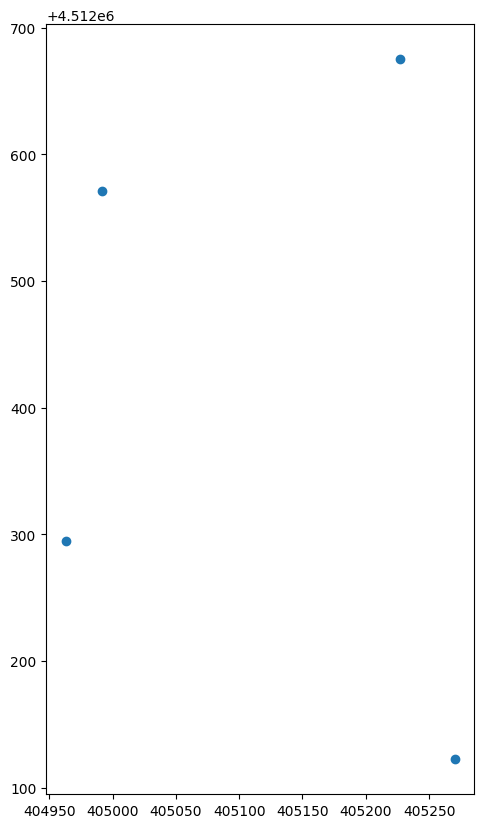

In [10]:
point_data.plot(figsize=(10, 10))

In [11]:
point_data.has_z

0    False
1    False
2    False
3    False
dtype: bool

Usando `has_z` ho verificato se i quattro punti sono effettivamente piani e quel `False` per ognuno di loro mi conferma che lo sono. Non resta che aggiungere la terza quota.

In [12]:
point_z_list = []

for _index, row in point_data.iterrows():
    point_geometry = row.geometry.coords
    # Estraggo la coppia di coordinate
    coordinates_plane = point_geometry[0]
    # Creo una lista con la coppia di coordinate ed aggiungo la z
    coordinates_3d = list(coordinates_plane)
    coordinates_3d.append(10)
    # Converto la lista in PointZ ed aggiungo l'oggetto alla lista di punti
    point_geometry_3d = Point(tuple(coordinates_3d))
    point_z_list.append([row.fid, point_geometry_3d])

# Ricostruisco il GeoDataFrame di punti
df = pd.DataFrame(point_z_list)
df.rename(columns={0:'fid', 1: 'geometry'}, inplace=True)
gdf = gpd.GeoDataFrame(df, geometry=df.geometry, crs=point_data.crs)
gdf

,fid,geometry
0,1.0,POINT Z (405270.221 4512122.298 10.000)
1,2.0,POINT Z (405226.798 4512675.034 10.000)
2,3.0,POINT Z (404962.921 4512294.350 10.000)
3,4.0,POINT Z (404991.893 4512570.669 10.000)


In [13]:
gdf.has_z

0    True
1    True
2    True
3    True
dtype: bool

Interrogando i dati nuovamente con `has_z` risultano essere 3D.

# 2. Quota altimetrica da DEM
Caso più complesso e sicuramente corrispondente alla realtà.

Il primo step è leggere la fonte dati raster. In verità dovrei leggere anche la fonte vettoriale ma siccome l'ho già fatto nell'esempio precedente evito di duplicare il passaggio.

In [14]:
raster_data = rio.open(dem)
raster_data

<open DatasetReader name='/media/max/Windows11/DEV/MIO/PyGIS_blog/sample_data/add_z/clip_dem.tif' mode='r'>

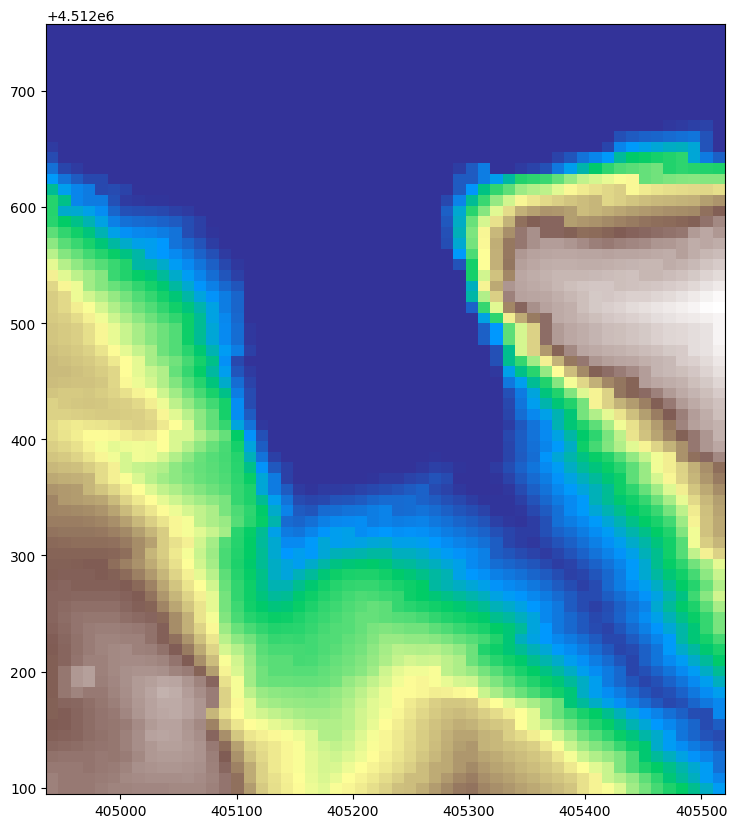

<Axes: >

In [15]:
figure, axes = plt.subplots(figsize=(10, 10))
show(
    source=raster_data,
    cmap='terrain'
)

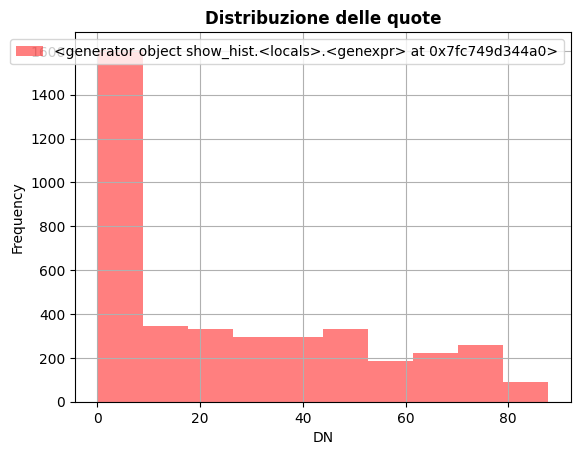

In [16]:
show_hist(
    source=raster_data,
    title='Distribuzione delle quote',
    bins=10,
    alpha=0.5,
)

L'istogramma delle quote ci consente di capire che c'è una forte presenza di quote zero che corrispondono all'azzurro del raster precedentemente stampato.

In [17]:
point_z_list = []

for _index, row in point_data.iterrows():
    point_geometry = row.geometry.xy
    # Estraggo la coppia di coordinate
    x_coords = point_geometry[0][0]
    y_coords = point_geometry[1][0]
    # Individuo la riga e la colonna del raster in cui ricade
    # la coppia di coordinate.
    line, column = raster_data.index(x_coords, y_coords)
    # Estraggo il valore della cella dall'intersezione della
    # riga e colonna individuate al passaggio precedente.
    # E' il valore di quota che sto cercando.
    pixel_value = raster_data.read(1)[line, column]
    # Creo il PointZ ed aggiungo l'oggetto alla lista di punti
    point_geometry_3d = Point((x_coords, y_coords, pixel_value))
    point_z_list.append([row.fid, point_geometry_3d])

# Ricostruisco il GeoDataFrame di punti
df = pd.DataFrame(point_z_list)
df.rename(columns={0:'fid', 1: 'geometry'}, inplace=True)
gdf = gpd.GeoDataFrame(df, geometry=df.geometry, crs=point_data.crs)
gdf

,fid,geometry
0,1.0,POINT Z (405270.221 4512122.298 53.347)
1,2.0,POINT Z (405226.798 4512675.034 0.000)
2,3.0,POINT Z (404962.921 4512294.350 65.504)
3,4.0,POINT Z (404991.893 4512570.669 18.646)


In [18]:
gdf.has_z

0    True
1    True
2    True
3    True
dtype: bool

Anche in questo caso la verifica sulla tridimensionalità del GeoDataFrame ha dato esito positivo.

# 2bis. Quota altimetrica da DEM *usando rioxarray*
Aggiornamento del 07-04-2022

Procedura simile alla precedente con la sola differenza legata al tipo di libreria con cui vado a leggere il DEM; andrò ad usare infatti [rioxarray](https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html) estensione di [xarray](https://docs.xarray.dev/en/stable/).

In [19]:
import rioxarray as rxr

new_raster_data = rxr.open_rasterio(dem).squeeze()
new_raster_data

<xarray.DataArray (y: 72, x: 55)>
[3960 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 4.049e+05 4.05e+05 4.05e+05 ... 4.055e+05 4.055e+05
  * y            (y) float64 4.513e+06 4.513e+06 ... 4.512e+06 4.512e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999.0
    scale_factor:   1.0
    add_offset:     0.0

In [20]:
new_point_z_list = []

for _index, row in point_data.iterrows():
    point_geometry = row.geometry.xy
    # Estraggo la coppia di coordinate
    x_coords = point_geometry[0][0]
    y_coords = point_geometry[1][0]

    # Individuo la riga e la colonna del DataArray in cui ricade
    # la coppia di coordinate.
    value = new_raster_data.sel(x=x_coords, y=y_coords, method="nearest")
    # Estraggo il valore della cella dall'intersezione della
    # riga e colonna individuate al passaggio precedente.
    # E' il valore di quota che sto cercando.
    pixel_value = value.data
    # Creo il PointZ ed aggiungo l'oggetto alla lista di punti
    point_geometry_3d = Point((x_coords, y_coords, pixel_value))
    new_point_z_list.append([row.fid, point_geometry_3d])

# Ricostruisco il GeoDataFrame di punti
new_df = pd.DataFrame(new_point_z_list)
new_df.rename(columns={0:'fid', 1: 'geometry'}, inplace=True)
new_gdf = gpd.GeoDataFrame(new_df, geometry=new_df.geometry, crs=point_data.crs)
new_gdf

,fid,geometry
0,1.0,POINT Z (405270.221 4512122.298 53.347)
1,2.0,POINT Z (405226.798 4512675.034 0.000)
2,3.0,POINT Z (404962.921 4512294.350 65.504)
3,4.0,POINT Z (404991.893 4512570.669 18.646)


# Conclusione

Quelli riportati sono solo due dei metodi possibili per raggiungere l'obiettivo, sono quelli che ho individuato io ma potrebbero essercene altri.
Nota bene che per **2** è indispensabile che raster e punti abbiano lo stesso sistema di riferimento!